(also used for deemp adjustment on Jason)

In [25]:
%load_ext autoreload
%autoreload 2

from base64 import b64encode
import copy
from datetime import datetime
import getopt
import io
from io import BytesIO
import os
import sys


import json

# standard numeric/scientific libraries
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 

# plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('figure', figsize=(20, 12))

# image display
from PIL import Image
import IPython.display 
from IPython.display import HTML

#internal libraries which may or may not get used
import fdls
from lddutils import *

import lddecode_core as ldd

# Notebook-only functions go here

# Draws a uint16 image, downscaled to uint8
def draw_raw_bwimage(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
matplotlib.rc('figure', figsize=(20, 12))

In [27]:
def write_json(ldd, outname):
    jsondict = ldd.build_json(ldd.curfield)
    
    fp = open(outname + '.tbc.json.tmp', 'w')
    json.dump(jsondict, fp, indent=4)
    fp.write('\n')
    fp.close()
    
    os.rename(outname + '.tbc.json.tmp', outname + '.tbc.json')


In [34]:
from lddecode_core import *

outname = 'devbook'
system = 'PAL'
foutput = False
loader = load_packed_data_4_40

# I found that the frame 15492 of Mammoth Mountain Adventure - with full/overdone MTF -
# had many single-line TBC errors, so I used that at first...

filename = '/home/cpage/ldtest/pal/jason-cbar1.lds'
firstframe = 0
req_frames = 2

ldd = LDdecode(filename, outname, loader, system=system, digital_audio=True)
ldd.roughseek(firstframe)
#ldd.blackIRE = 0

#ldd.rf.mtf_mult = 0.35

fields = []
for i in range(0, req_frames * 2):
    fields.append(ldd.readfield())
    #ldd.processfield(fields[-1])

write_json(ldd, outname)

file frame 0 CAV frame 51398
file frame 1 CAV frame 51399


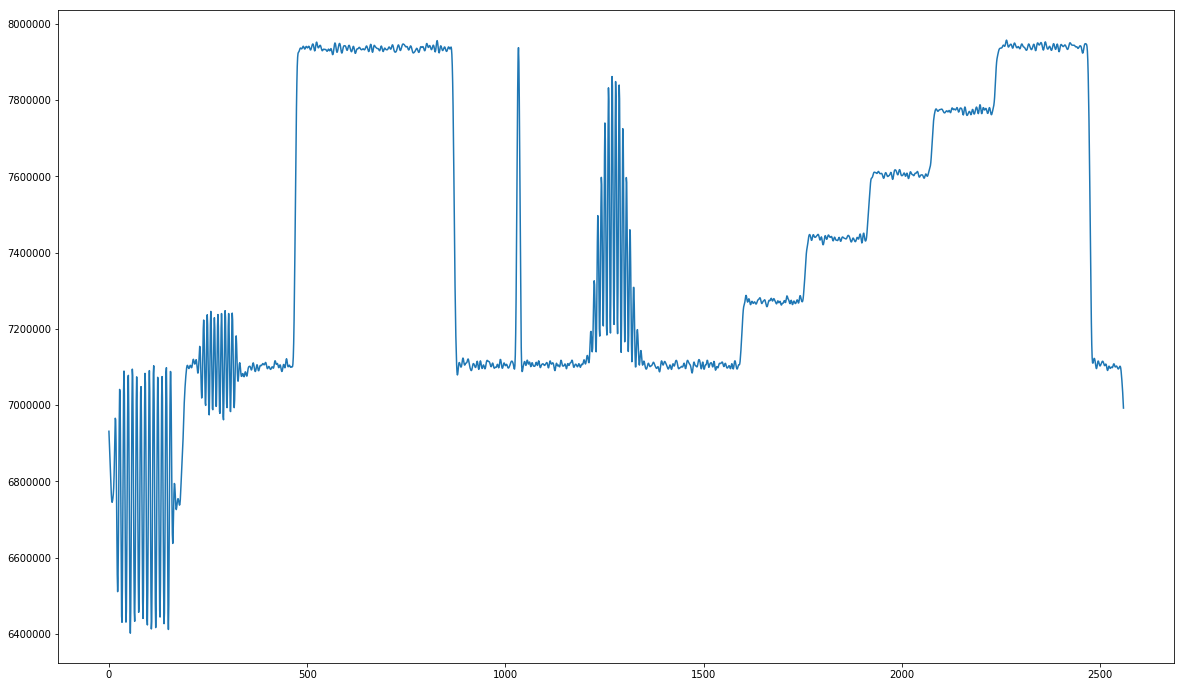

In [36]:
f = fields[2]
sl = f.lineslice(19, 0, 64)
data = f.data[0]['demod'][sl]

plt.plot(data)

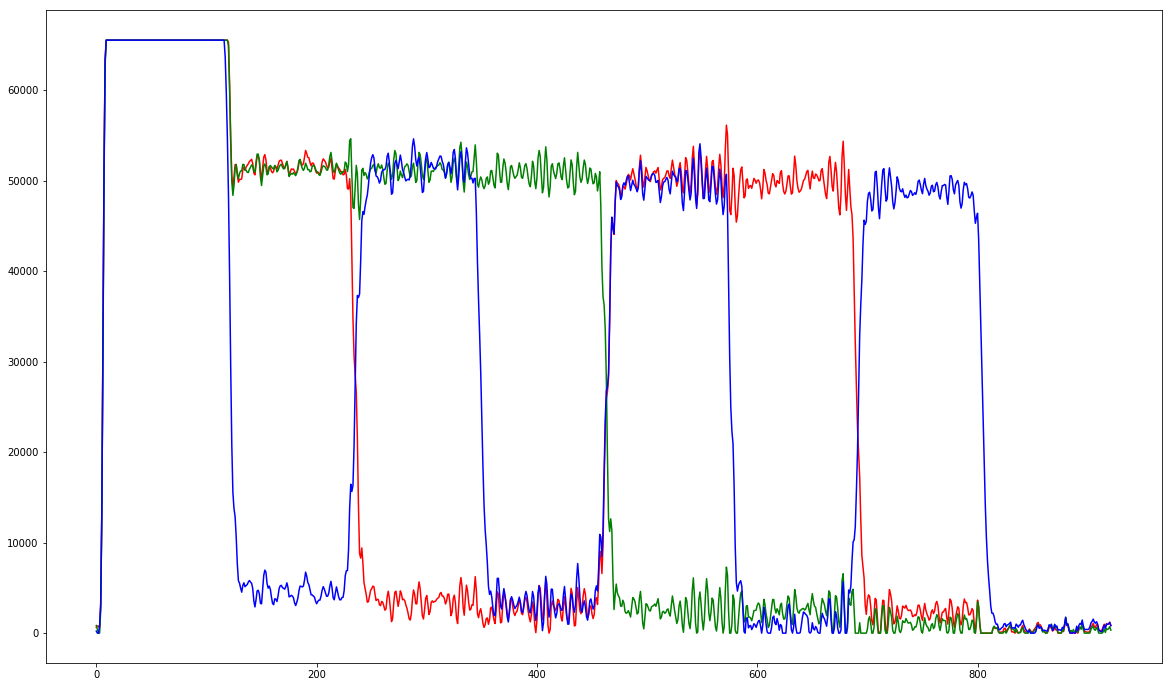

In [5]:
os.system('tools/ld-comb-pal/ld-comb-pal {0}.tbc {0}.rgb'.format(outname))
with open(outname + '.rgb', 'rb') as fd:
    inbuf = fd.read()
    
rgb = np.frombuffer(inbuf, 'uint16', len(inbuf) // 2)

x = 922
y = 576

imgsize = x * 3 * y
rgba = rgb.reshape((int(len(rgb)/imgsize), y, x*3))

l = rgba[1][200]

plt.plot(l[0::3], color='r')
plt.plot(l[1::3], color='g')
plt.plot(l[2::3], color='b')

In [37]:
ldd.fieldinfo

[{'isFirstField': True,
  'syncConf': 75,
  'seqNo': 1,
  'audioSamples': 958,
  'diskLoc': 0.8,
  'medianBurstIRE': 9.172482598799249,
  'dropOuts': {'fieldLine': [], 'startx': [], 'endx': []},
  'decodeFaults': 0},
 {'isFirstField': False,
  'syncConf': 75,
  'seqNo': 2,
  'audioSamples': 962,
  'diskLoc': 1.8,
  'medianBurstIRE': 9.155251740614252,
  'dropOuts': {'fieldLine': [], 'startx': [], 'endx': []},
  'decodeFaults': 0,
  'vitsMetrics': {'whiteSNR': 41.41479224023564,
   'blackLineF1PreTBCIRE': 0.36614527616242415,
   'blackLineF2PreTBCIRE': 0.6000631345725851,
   'blackLineF1PostTBCIRE': 0.537361400309841,
   'blackLineF2PostTBCIRE': 0.6126319609016164,
   'blackLineF1PSNR': 39.17299777289345,
   'blackLineF2PSNR': 39.40463433996285},
  'frameNumber': 51398},
 {'isFirstField': True,
  'syncConf': 75,
  'seqNo': 3,
  'audioSamples': 959,
  'diskLoc': 2.8,
  'medianBurstIRE': 13.863423957839967,
  'dropOuts': {'fieldLine': [], 'startx': [], 'endx': []},
  'decodeFaults': 0},
 

In [7]:
f1 = fields[2]
f2 = fields[3]

In [9]:
blackline = 22

bl_slice1 = f1.lineslice(blackline - 0 + f1.lineoffset, 12, 50)
bl_slice2 = f2.lineslice(blackline - 0 + f2.lineoffset, 12, 50)
f1.rf.hztoire(np.mean(f1.data[0]['demod'][bl_slice1])), f2.rf.hztoire(np.mean(f2.data[0]['demod'][bl_slice2]))

(0.7098607762819156, 0.8789232870033011)

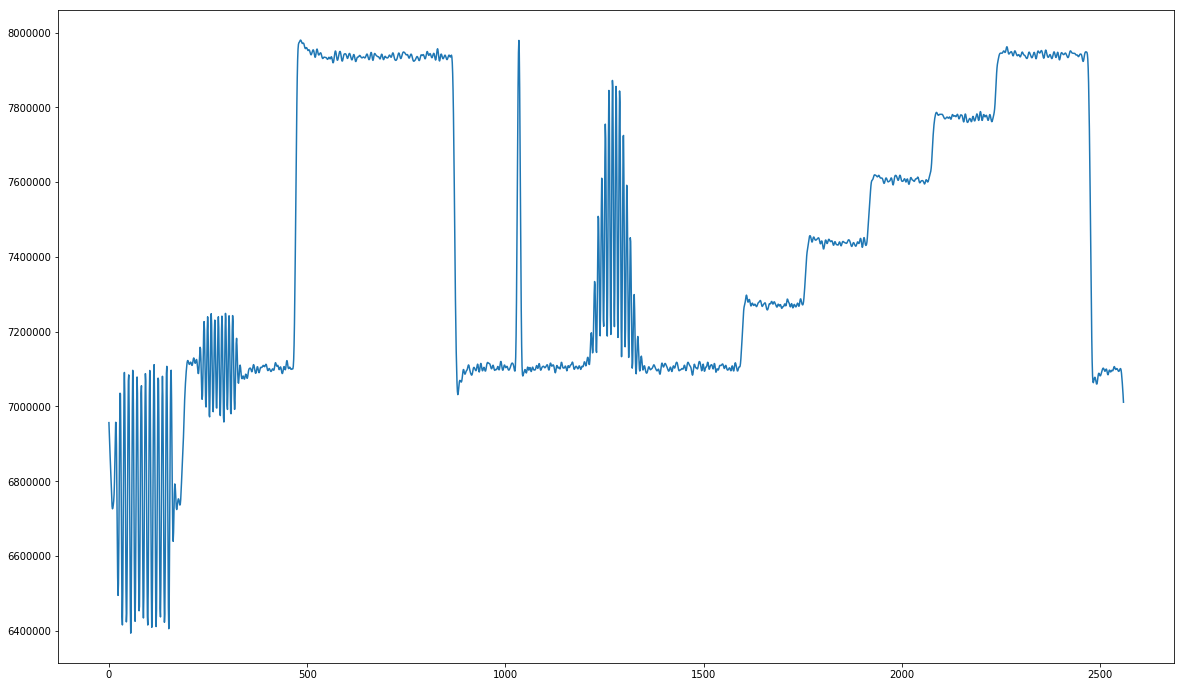

In [14]:
f = fields[2]
sl = f.lineslice(19 + f.lineoffset, 0, 64)
data = f.data[0]['demod'][sl]

plt.plot(data)

(3.355235784087432, 44.1875248171956)

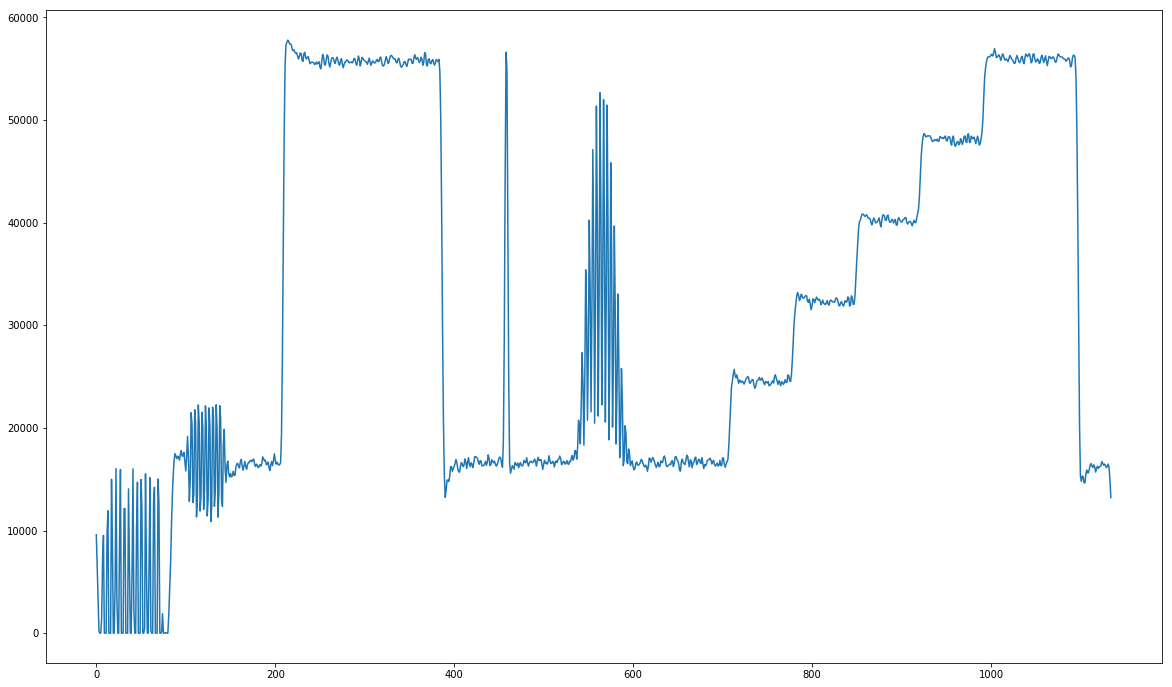

In [13]:
f = fields[2]
wl_slice = f.lineslice_tbc(19, 0, 64)
plt.plot(f.dspicture[wl_slice])
ldd.calcsnr(f, wl_slice), np.mean(f.output_to_ire(f2.dspicture[wl_slice]))